<a href="https://colab.research.google.com/github/aikyashah/cifar_10_class/blob/master/insightChallengeAikyaShah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To connect to a GPU runtime for faster training (highly recommended):
1. Go to Runtime > Change runtime type from topbar.
1. Select GPU from the Hardware accelerator dropdown list.

In [0]:
#@title Set Caliper credentials (Paste this notebook's URL here)
############################################################
##            DON'T EDIT CODE IN THIS CELL                ##
############################################################
NOTEBOOK_URL = "https://colab.research.google.com/drive/1s6bwVZXAYDQMZAsEFYRk4SHhJbX5VbEL#scrollTo=OIlDSqXu-QCi" #@param {type:"string"}
import urllib
parsed = urllib.parse.urlparse(NOTEBOOK_URL)
try:
  caliper_token = urllib.parse.parse_qs(parsed.query)['auth_token'][0]
  challenge_id = urllib.parse.parse_qs(parsed.query)['challenge_id'][0]
  phase_id = urllib.parse.parse_qs(parsed.query)['phase_id'][0]
except:
  print("Some error occured in parsing the pasted URL.")
############################################################
##            DON'T EDIT CODE IN THIS CELL                ##
############################################################

Some error occured in parsing the pasted URL.


In [1]:
#@title Import dependencies
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import os
from google.colab import files

Using TensorFlow backend.


In [0]:
#@title Set hyperparameters
batch_length = 200
num_of_epoch = 100
dropout_Conv = 0.2
dropuout_Dense = 0.5
model_name = 'deep1.h5'
model_path = os.path.join(os.getcwd(), model_name)

In [0]:
# Normalize training values between [0, 1]. Apply sheer and zoom to prepare for test dataset
# Classes are translated into one Hot vectors of length 10
def processTrainingData():
    (X_train,y_train),(X_test, y_test) = cifar10.load_data()
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    train_datagen = ImageDataGenerator(shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)
    train_datagen.fit(X_train)
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test,10)
    return X_train, y_train, X_test, y_test

In [0]:
#Generates CSV
def generateAndDownLoadCSV(y_hat):
    import csv
    header = ['img_id', 'label']
    with open("test_predictions_Aikya_Shah.csv", "w", newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(header)
        index = 1
        for item in y_hat:
            writer.writerow([index, item])
            index += 1
    files.download('test_predictions_Aikya_Shah.csv')
    #files.upload('test_predictions_Aikya_Shah.csv')

In [0]:
# A model with 5 convolution layers and each with 2x2 Max pooling 
# connected with a fully connected Neural Network with 2 hidden layers    
def getCNNModel():
    classifier = Sequential()
    
    classifier.add(Convolution2D(32, (3, 3), kernel_initializer='he_uniform', 
                                 padding='same', 
                                 input_shape = (32, 32, 3), 
                                 activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Convolution2D(32, (3, 3), kernel_initializer='he_uniform', 
                                 activation = 'relu', 
                                 padding='same'))
    classifier.add(Dropout(dropout_Conv))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Convolution2D(64, (3, 3), kernel_initializer='he_uniform', 
                                 activation = 'relu', 
                                 padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Convolution2D(64, (3, 3), kernel_initializer='he_uniform', 
                                 activation = 'relu', 
                                 padding='same'))
    classifier.add(Convolution2D(64, (3, 3), kernel_initializer='he_uniform', 
                                 activation = 'relu', 
                                 padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(dropout_Conv))
    classifier.add(Convolution2D(128, (3, 3), kernel_initializer='he_uniform', 
                                 activation = 'relu', 
                                 padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(dropout_Conv))
    #Flatten the output to 1-D array to as input to Fully Connected Neural Net
    classifier.add(Flatten())
    
    classifier.add(Dense(units = 512, 
                         kernel_initializer = 'he_uniform', 
                         activation = 'relu'))
    classifier.add(Dropout(dropuout_Dense))
    classifier.add(Dense(units = 128, 
                         kernel_initializer ='he_uniform', 
                         activation = 'relu'))
    classifier.add(Dropout(dropuout_Dense))
    classifier.add(Dense(units = 64, 
                         kernel_initializer ='he_uniform', 
                         activation = 'relu'))
    classifier.add(Dropout(dropuout_Dense))
    classifier.add(Dense(units = 10, activation = 'softmax'))
    
    # Used categorical_crossentropy because this is not a binary classification
    classifier.compile(optimizer = 'adam', 
                       loss = 'categorical_crossentropy', 
                       metrics = ['accuracy'])
    
    return classifier

In [0]:
# Plots of Cross Entropy Loss vs Epoch and Prediction Accuracy vs Epochs
def generateAccuracyPlot(history):
    plt.title('Cross Entropy Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(history.history['loss'], color='red', label='train')
    #Uncomment if validation set is given while training
    #plt.plot(history.history['val_loss'], color='blue', label='test')
    plt.legend(loc="upper right")
    plt.show()
    plt.close()
    
    plt.title('Classification Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(history.history['acc'], color='green', label='train')
    #Uncomment if validation set is given while training
    #plt.plot(history.history['val_acc'], color='blue', label='test')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

In [0]:
#@title Build the model

def main():
    X_train, y_train, X_test, y_test = processTrainingData()
    model = getCNNModel()
    training_metrics = model.fit(X_train, y_train, 
                                 batch_size=batch_length, 
                                 epochs = num_of_epoch, 
                                 #validation_split = 0.1, 
                                 verbose = 2)
    #Save the model to use it again without training
    model.save(model_path)
    #print(training_metrics.history)
    y_pred = model.predict_classes(X_test)
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print('Test Accuracy is: '+'%.2f' % (test_accuracy * 100.0)+"%")
    generateAccuracyPlot(training_metrics)
    generateAndDownLoadCSV(y_pred)

170500096/170498071 [==============================] - 2s 0us/step





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





 - 19s - loss: 2.3041 - acc: 0.1257
Epoch 2/100
 - 3s - loss: 1.9389 - acc: 0.2174
Epoch 3/100
 - 3s - loss: 1.7729 - acc: 0.2871
Epoch 4/100
 - 3s - loss: 1.6223 - acc: 0.3744
Epoch 5/100
 - 3s - loss: 1.5019 - acc: 0.4319
Epoch 6/100
 - 3s - loss: 1.3909 - acc: 0.4842
Epoch 7/100
 - 3s - loss: 1.3135 - acc: 0.5252
Epoch 8/100
 - 3s - loss: 1.2407 - acc: 0.5611
Epoch 9/100
 - 3s - loss: 1.1867 - acc: 0.5861
Epoch 10/100
 - 3s - loss: 1.1301 - acc: 0.6121
Epoch 11/100
 - 3s - loss: 1.0704 - acc: 0.6347
Epoch 12/100
 - 3s - loss: 1.0433 - acc: 0.6441
Epoch 13/100
 - 3s - loss: 1.0031 - acc: 0.6617
Epoch 14/100
 - 3s - loss: 0.9678 - acc: 0.6758
Epoch 15/100
 - 3s - loss: 0.9402 - acc: 0.68

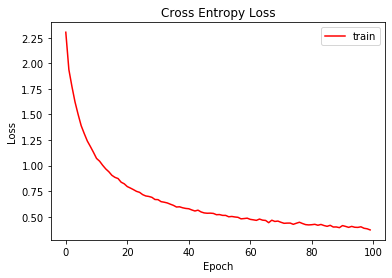

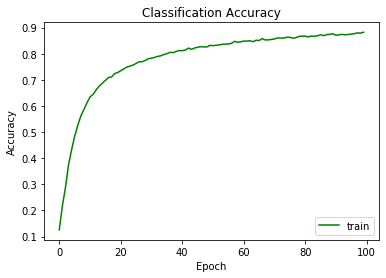

MessageError: ignored

In [10]:
if __name__ == "__main__":
    main()

# New Section

If the above does not download a predictions CSV file to your machine (known issue on Firefox):

1. Go to View > Table of contents from topbar.
1. A left sidebar will show up. Open the Files tab.
1. Click Refresh.
1. Right-click and download caliper_mnist_test_predictions.csv.